## Code for fitting and plotting fluorescence anisotropy binding data for SERF-TAR interaction ##
This script takes one input text file, which contains concentration values ([:,0]), average anisotropy values ([:,1]), and standard deviations ([:,2]) for SERF-TAR binding. In this experiment, the RNA was fluorescently labeled and served as the source of signal for equilibrium binding measurements.

In [1]:
## import packages ##

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy import optimize

In [3]:
## load file containing binding data ##

data = np.loadtxt('FA_SERF-TAR.txt')


In [4]:
## set variables ##

x = data[:,0]
y = data[:,1]
yerr = data[:,2]

# generate x values covering the range of experimental concentrations for fitting 
xfit = np.arange(min(x)+0.005, max(x)+5, 0.01)

# set constants used for fitting

# Af == anisotropy of unbound fluorescent species (constant)
# Ab == anisotropy of fully bound fluorescent species (constant)
# FAM == concentration of fluorescently labeled RNA (constant)
Af = min(y)
Ab = max(y)
FAM = 0.200

guess = [1, 3]

In [5]:
## define 1:1 binding model (corresponds to Eq. 8 & 9) ##

# Kd == dissociation constant in μM (fitted), guess = 1
# Q == dimensionless correction value to account for differences in absolute fluorescence intensities in free vs. bound states (fitted), guess = 3

def kdfit(x, Kd, Q):
    # first define fraction bound (FB)
    FB = (((Kd + x + FAM) - np.sqrt(((Kd + x + FAM) **2) - 4 * x * FAM)) / (2 * FAM))
    
    Aobs = ((Q * FB * Ab) + ((Af * (1 - FB)) / (1 - (FB * (1 - Q)))))
    
    return Aobs

guess = [1, 3]

# generate fitted y data based on best fit parameters
p1, pcov1 = optimize.curve_fit(kdfit, x, y, guess)
fitted = np.array(kdfit(xfit, p1[0], p1[1]))
Kerr = np.sqrt(np.diag(pcov1))

fit_out = [xfit, fitted]
params_out = [[p1[0], p1[1]], Kerr]

# uncomment below to write out xy fit values and fitted parameters
#np.savetxt('SERF-TAR_fit.txt', fit_out)
#np.savetxt('SERF-TAR_pars.txt', params_out)

In [6]:
## organize for plotting ##

Kdround = np.round(params_out[0][0], 2)
Kderr = np.round(params_out[1][0], 2)

residuals = np.array(kdfit(x, p1[0], p1[1])) - y

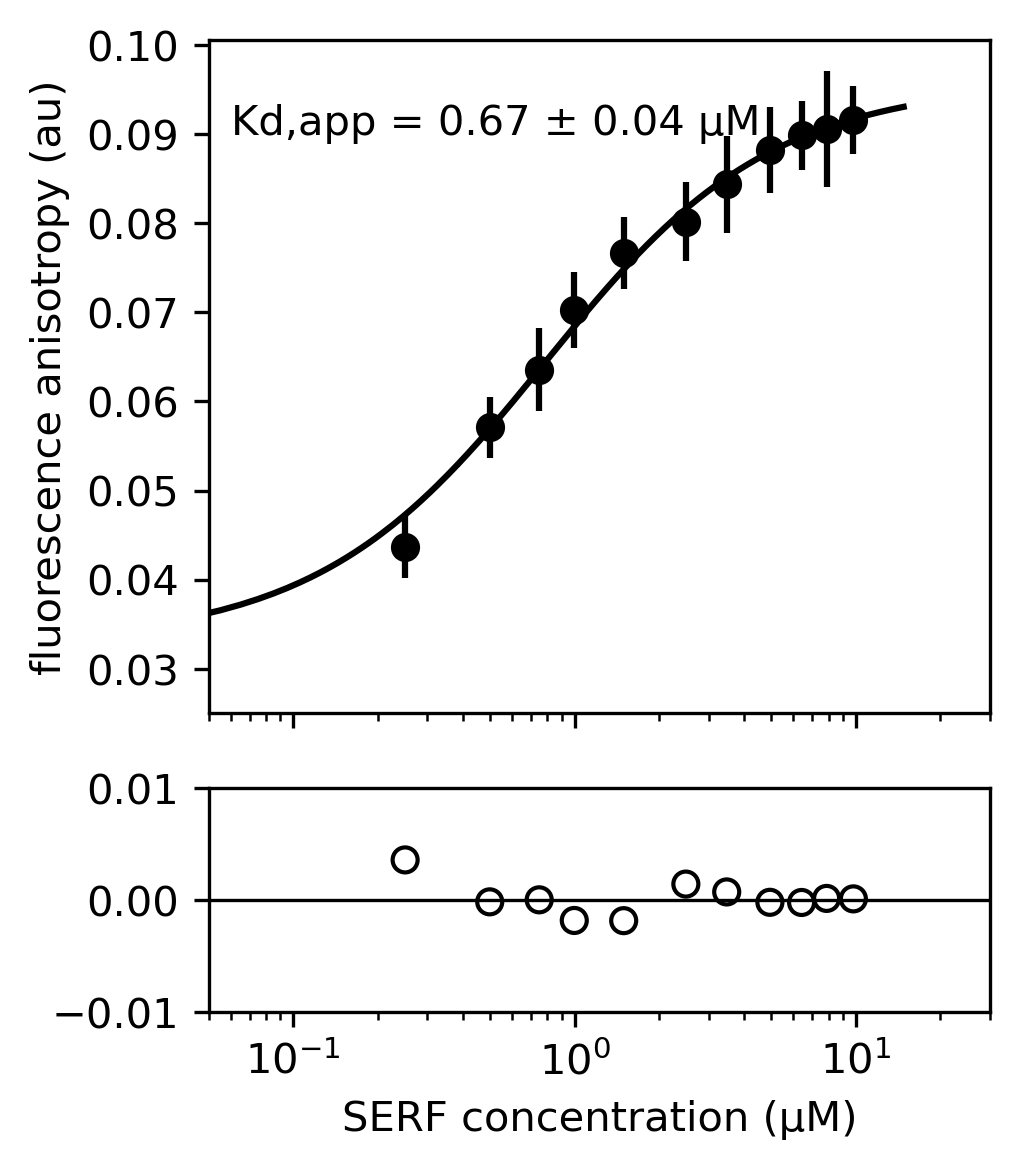

In [12]:
# generate "fitted" values for actual SERF concentrations in dataset (not interpolated)
# create subplot
f, (a0, a1) = plt.subplots(2, 1, figsize = (3.5,4), sharex = True, dpi = 300, gridspec_kw={'height_ratios': [3, 1]})

a0.scatter(x, y, color = 'k')
a0.plot(xfit, fitted, color = 'k')
a0.errorbar(x, y, yerr = yerr, fmt = 'none', ecolor = 'k')

a1.scatter(x, residuals, edgecolor = 'k', facecolor = "None")
a1.axhline(y = 0, color = 'k', lw = 0.8)

a1.set_ylim([-0.01, 0.01])

plt.xlabel('SERF concentration (μM)')
a0.set_ylabel('fluorescence anisotropy (au)') 
plt.xscale('log')

plt.xlim([0.05, 30])

text = 'Kd,app = ' +str(Kdround)+ ' ± ' +str(Kderr)+ ' μM'
a0.annotate(text, xy = (0.06, 0.09))

plt.tight_layout()

## UNCOMMENT BELOW TO SAVE AS PDF ##
#plt.savefig('SERF-TAR_binding_fit.pdf', format = 'pdf', dpi = 300)

plt.show()